# Imports & data!

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.notebook import tqdm
import GPyOpt
import random
from IPython.display import clear_output
import time

In [2]:
# set seeds 
seed=42
random.seed(seed)  # Python
np.random.seed(seed)  # NumPy
torch.manual_seed(seed)  # PyTorch
torch.cuda.manual_seed_all(seed)  # PyTorch CUDA

In [3]:
# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR10 datasets
data_dir = './CIFAR10_data'
full_trainset = datasets.CIFAR10(data_dir, download=True, train=True, transform=transform)
full_testset = datasets.CIFAR10(data_dir, download=True, train=False, transform=transform)

# Define the size of the subset for training and validation
subset_size = 160  # Limit to 100 samples for both training and validation

# Create indices for the subset
train_indices = np.arange(subset_size)
test_indices = np.arange(subset_size)

# Create subset datasets
trainset = Subset(full_trainset, indices=train_indices)
testset = Subset(full_testset, indices=test_indices)

# Create DataLoaders from the subset datasets with a batch size of 1
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
val_loader = DataLoader(testset, batch_size=16, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np

# Define the transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the full CIFAR10 datasets
data_dir = './CIFAR10_data'
full_trainset = datasets.CIFAR10(data_dir, download=True, train=True, transform=transform)
full_testset = datasets.CIFAR10(data_dir, download=True, train=False, transform=transform)

# Define the size of the subset for training and validation
subset_size = 6400

# Create indices for the subset
train_indices = np.arange(subset_size)
test_indices = np.arange(subset_size)

# Create subset datasets
trainset = Subset(full_trainset, indices=train_indices)
testset = Subset(full_testset, indices=test_indices)

# Create DataLoaders from the subset datasets with a batch size of 16
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
val_loader = DataLoader(testset, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


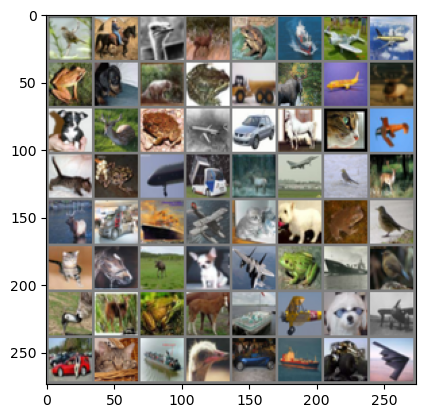

In [5]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

# example showcase
def imshow(img):
    img = img / 2 + 0.5 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # convert from Tensor image
    plt.show()

imshow(torchvision.utils.make_grid(images))

# Model architecture!

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self, in_channels, num_classes, num_neurons, kernel_size):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        # Placeholder for the dynamic size calculation
        self.num_neurons = num_neurons
        self.num_classes = num_classes
        self.kernel_size = kernel_size

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Dynamically calculate the size based on the tensor dimensions
        num_features = x.size(1) * x.size(2) * x.size(3)
        if not hasattr(self, 'fc1'):
            # Initialize FC layers here to use dynamic size
            self.fc1 = nn.Linear(num_features, self.num_neurons)
            self.fc2 = nn.Linear(self.num_neurons, self.num_classes)
            self.fc1 = self.fc1.to(x.device)
            self.fc2 = self.fc2.to(x.device)
        
        #print(f"Size before view: {x.size()}")  # For debugging
        x = x.view(-1, num_features)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Training structure!

In [7]:
def train_and_evaluate_model(model, trainloader, val_loader, lr, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
            inputs, labels = inputs.to(device), labels.to(device)
            if inputs.shape[0] != trainloader.batch_size:
                continue

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        train_epoch_loss = train_loss / len(trainloader.dataset)
        train_epoch_acc = train_corrects.double() / len(trainloader.dataset)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            inputs, labels = inputs.to(device), labels.to(device)
            if inputs.shape[0] != val_loader.batch_size:
                continue

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)
        print(f'Training Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print(f'Validation Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
    
    clear_output(wait=True)
    
    print(f'Best Training Accuracy: {train_epoch_acc:.4f}')
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')
    return best_val_acc

In [8]:
def train_and_evaluate_model(model, trainloader, val_loader, lr, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in tqdm(trainloader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
            inputs, labels = inputs.to(device), labels.to(device)
            if inputs.shape[0] != trainloader.batch_size:
                continue  # Skip the loop iteration if batch size is not equal to trainloader's batch size

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            train_loss += loss.item() * inputs.size(0)
            train_corrects += torch.sum(preds == labels.data)

        # Calculate training loss and accuracy for the epoch
        train_epoch_loss = train_loss / len(trainloader.dataset)
        train_epoch_acc = train_corrects.double() / len(trainloader.dataset)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
            inputs, labels = inputs.to(device), labels.to(device)
            if inputs.shape[0] != val_loader.batch_size:
                continue

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_corrects.double() / len(val_loader.dataset)

        # Update best validation accuracy if current epoch's accuracy is higher
        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc

    # Print best training and validation accuracy after training completes
    clear_output(wait=True)
    print(f'Best Training Accuracy: {train_epoch_acc:.4f}')
    print(f'Best Validation Accuracy: {best_val_acc:.4f}')

    # Return the NEGATIVE of the best validation accuracy for optimization
    return best_val_acc.cpu().numpy()

# Random search!

In [23]:
# domain of the hyperparameters
domain = [{'name': 'num_neurons', 'type': 'discrete', 'domain': np.arange(64, 257)},
          {'name': 'lr', 'type': 'continuous', 'domain': (1e-4, 1e-2)}]
          #{'name': 'kernel_size', 'type': 'discrete', 'domain': np.array([3, 5, 7])}]
kernel_size = 3

In [10]:
counter = 0

def objective(x):
    global counter
    counter += 1
    print(f"Iteration {counter}")
    num_neurons = int(x[0, 0])
    lr = x[0, 1]
    kernel_size = int(x[0, 2])
    
    # Instantiate model
    model_instance = SimpleCNN(in_channels=3, num_classes=10, num_neurons=num_neurons, kernel_size=kernel_size)
    
    # model instance to training and evaluation
    evaluation = train_and_evaluate_model(model_instance, trainloader, val_loader, lr, num_epochs=10)
    return evaluation

In [11]:
def random_search_objective(objective, domain, max_iter):
    best_params = None
    best_objective = None

    for _ in range(max_iter):
        # Randomly sample from the domain
        num_neurons = random.choice(np.arange(64, 257))
        lr = random.uniform(1e-4, 1e-2)
        kernel_size = random.choice([3, 5])
        
        # Pack the parameters in the same format as your objective function expects
        x = np.array([[num_neurons, lr, kernel_size]])
        
        # Evaluate the objective function
        evaluation = objective(x)

        # If this is the first evaluation or if it's better than the best one so far, update the best parameters and objective
        if best_objective is None or evaluation < best_objective:
            best_params = x
            best_objective = evaluation

        clear_output(wait=True)

    return best_params, best_objective

best_params, best_objective = random_search_objective(objective, domain, max_iter=1)

Best Training Accuracy: 0.5244
Best Validation Accuracy: 0.4609


In [12]:
print(f"Best parameters found (Random Search): Num_neurons={best_params[0,0]}, lr={best_params[0,1]}, kernel_size={best_params[0,2]}")

Best parameters found (Random Search): Num_neurons=227.0, lr=0.001202177574840236, kernel_size=5.0


# Bayesian optimization!

In [13]:
counter = 0

def objective(x):
    global counter
    counter += 1 
    print(f"Iteration {counter}")

    num_neurons = int(x[0, 0])
    lr = x[0, 1]
    kernel_size = int(x[0, 2])
    
    model_instance = SimpleCNN(in_channels=3, num_classes=10, num_neurons=num_neurons, kernel_size=kernel_size)
    
    
    evaluation = train_and_evaluate_model(model_instance, trainloader, val_loader, lr, num_epochs=10)
    clear_output(wait=True)
    return evaluation

In [14]:
opt = GPyOpt.methods.BayesianOptimization(f=objective, domain=domain, acquisition_type ='EI')

opt.acquisition.exploration_weight = 0.5

# kan køre mere end n max_iter, da den også vil have nogle "kickstart" iterations ...
opt.run_optimization(max_iter = 1)

Best Training Accuracy: 0.4727
Best Validation Accuracy: 0.4123


In [21]:
# Print the best found parameters in the desired format
print(f"Best parameters found (Bayesian optimization): Num_neurons={opt.x_opt[0]}, lr={opt.x_opt[1]}, kernel_size={int(opt.x_opt[2])}")

Best parameters found (Bayesian optimization): Num_neurons=166.0, lr=0.0010897516665982288, kernel_size=3


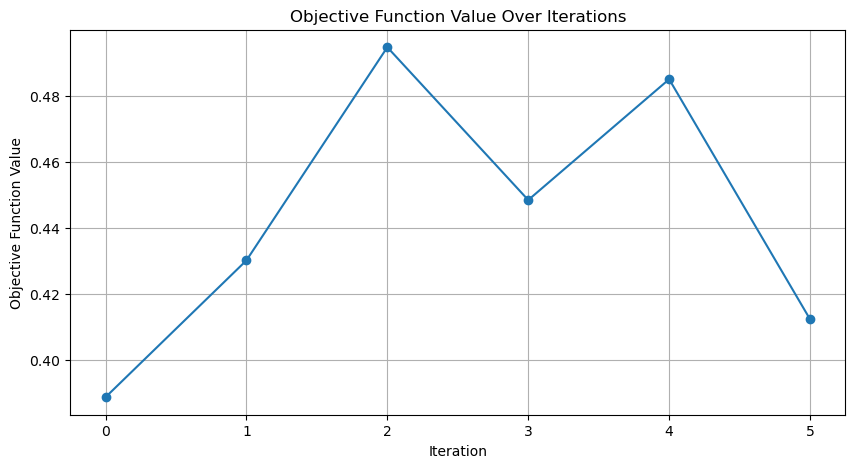

In [16]:
# Plotting the objective function value over iterations
plt.figure(figsize=(10, 5))
plt.plot(opt.Y, marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Objective Function Value Over Iterations')
plt.grid(True)
plt.show()